In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Embedding, Dropout, Flatten, UpSampling1D, UpSampling2D
from keras.layers.convolutional import Conv1D, Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling1D, AveragePooling1D, MaxPooling2D, AveragePooling2D
import keras.backend as K
import keras

from keras.layers import BatchNormalization, Activation
from keras.layers import Input
from keras.regularizers import l2

Using TensorFlow backend.


In [2]:
kernel_size, filters = 3, 16
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

In [3]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v2(input_shape, depth, num_classes=4):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=3)(x)
    y = Flatten()(x)
    y = Dense(num_classes*32,
                      activation='relu',
                      kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y)
    y = Dense(num_classes*16,
                      activation='relu',
                      kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y)
    y = Dense(num_classes*8,
                      activation='relu',
                      kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y)
      
    outputs = Dense(num_classes,
                    activation='linear',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [4]:
model = resnet_v2(input_shape=(34,21,2), depth=20, num_classes=4)

In [5]:
# 2D MODEL! OLD! Doesn't work! Gotta try L*L*20

# Create the model
# model = Sequential((
#     Conv2D(filters=filters, kernel_size=5, padding='valid', activation='relu', input_shape=(34,21,2)),
#     Dropout(0.1),
#     Conv2D(filters=filters, kernel_size=3, padding='valid', activation='relu'),
#     MaxPooling2D(pool_size=2),
#     Conv2D(filters=filters*2, kernel_size=3, padding='valid', activation='relu'),
#     Dropout(0.1),
#     Conv2D(filters=filters*2, kernel_size=1, padding='valid', activation='relu'),
#     Dropout(0.1),
#     Conv2D(filters=filters*2, kernel_size=1, padding='valid', activation='relu'),
#     MaxPooling2D(pool_size=2),
#     Conv2D(filters=filters*2, kernel_size=1, padding='valid', activation='relu'),
#     Flatten(),
#     Dense(64, activation="relu"),
#     Dropout(0.1),
#     Dense(32, activation="relu"),
#     Dense(4, activation="linear")
# ))
# # model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=["accuracy"])
# model.compile(loss="mean_squared_error", optimizer=adam, metrics=[])

In [6]:
# Create the model - 1D New! 
# model = Sequential((
#      Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu', input_shape=(34,42)),
#      Dropout(0.05),
#      Conv1D(filters=filters, kernel_size=kernel_size*3, padding='same', activation='relu'),
#     
#      MaxPooling1D(pool_size=2),
#      Conv1D(filters=filters*2, kernel_size=kernel_size*3, padding='same', activation='relu'),
#      Dropout(0.05),
#      Conv1D(filters=filters*2, kernel_size=kernel_size, strides=2, padding='same', activation='relu'),
#     
#      MaxPooling1D(pool_size=2),
#      Conv1D(filters=filters*4, kernel_size=kernel_size, strides=2, padding='same', activation='relu'),
#      Dropout(0.05),
#      Conv1D(filters=filters*4, kernel_size=kernel_size, strides=2, padding='same', activation='relu'),
#      # MaxPooling1D(pool_size=2),
#     
#      Conv1D(filters=4, kernel_size=kernel_size, padding='same', activation='softmax'),
#      Flatten()))
# # model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=["accuracy"])
# model.compile(loss="mean_squared_error", optimizer=adam, metrics=["mean_absolute_error"])

In [7]:
model.compile(optimizer=adam, loss="mean_squared_error", metrics=["mean_absolute_error"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 34, 21, 2)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 34, 21, 16)   304         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 34, 21, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 34, 21, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [8]:
outputs = np.genfromtxt("../data/distanced/ANGLES/outputs.txt")
outputs[np.isnan(outputs)] = 0.0
# Idea convert to sin/cos to remove angle periodicity
outputs.shape

(43001, 2)

In [9]:
out = []
out.append(np.sin(outputs[:,0]))
out.append(np.cos(outputs[:,0]))
out.append(np.sin(outputs[:,1]))
out.append(np.cos(outputs[:,1]))
out = np.array(out).T
print(out.shape)

(43001, 4)


In [10]:
def get_ins(path = "../data/distanced/ANGLES/input_aa.txt", pssm=None):
    # handle both files
    if pssm: path = "../data/distanced/ANGLES/input_pssm.txt"
    # Opn file and read text
    with open(path, "r") as f:
        lines = f.read().split('\n')
    # Extract numeric data from text
    pre_ins = []
    for i,line in enumerate(lines):
        # Read each protein separately
        if line == "NEW":
            prot = []
            raw = lines[i+1:i+35]
            # Read each line as a vector + ensemble one-hot vectors matrix
            for r in raw:
                prot.append(np.array([float(x) for x in r.split(" ") if x != ""]))
            # Add prot to dataset
            pre_ins.append(np.array(prot))  
    
    return np.array(pre_ins)

In [11]:
aas = get_ins()
pssms = get_ins(pssm=True)
# Check shapes match
print(aas.shape, pssms.shape)
# inputs = np.concatenate((aas, pssms), axis=2)
inputs = np.concatenate((aas.reshape((*aas.shape,1)), pssms.reshape((*pssms.shape,1))), axis=3)
# inputs = pssms.reshape((*aas.shape,1))
inputs.shape

(43001, 34, 21) (43001, 34, 21)


(43001, 34, 21, 2)

In [12]:
# print(np.sin(-1.61735004), np.cos(-1.61735004), np.arccos(1.61))
import matplotlib.pyplot as plt

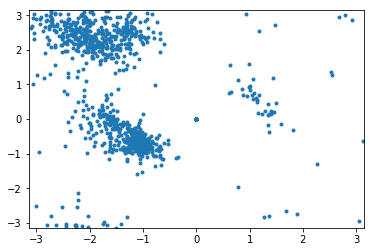

In [13]:
plt.scatter(outputs[:1000,0], outputs[:1000,1], marker=".")
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.show()

In [14]:
# Preprocess outputs (mean/std)
# mean = np.mean(inputs,axis=(0,1,2))
# std = np.std(inputs,axis=(0,1,2))
# print("Mean: ", mean)
# print("Std: ", std)
# pre_inputs = (inputs-mean)/(std+1e-7)

In [15]:
his = model.fit(pre_inputs, out, epochs=5, batch_size=16, verbose=1, shuffle=True, validation_split=0.1)

Train on 38700 samples, validate on 4301 samples
Epoch 1/5
38700/38700 [==============================] - 64s 2ms/step - loss: 0.5137 - mean_absolute_error: 0.4557 - val_loss: 0.4552 - val_mean_absolute_error: 0.4622
Epoch 2/5
38700/38700 [==============================] - 59s 2ms/step - loss: 0.3550 - mean_absolute_error: 0.4134 - val_loss: 0.3619 - val_mean_absolute_error: 0.4129
Epoch 3/5
38700/38700 [==============================] - 59s 2ms/step - loss: 0.3264 - mean_absolute_error: 0.3970 - val_loss: 0.3328 - val_mean_absolute_error: 0.4239
Epoch 4/5
38700/38700 [==============================] - 60s 2ms/step - loss: 0.3133 - mean_absolute_error: 0.3882 - val_loss: 0.3222 - val_mean_absolute_error: 0.4003
Epoch 5/5
38700/38700 [==============================] - 59s 2ms/step - loss: 0.3051 - mean_absolute_error: 0.3825 - val_loss: 0.3352 - val_mean_absolute_error: 0.4060


In [23]:
n = 30000
preds = model.predict(inputs)

In [24]:
# Get angle values from sin and cos
refactor = []
for pred in preds:
    angles = []
    phi_sin, phi_cos, psi_sin, psi_cos = pred[0], pred[1], pred[2], pred[3]
    # PHI - First and fourth quadrant
    if (phi_sin>=0 and phi_cos>=0) or (phi_cos>=0 and phi_sin<=0):
        angles.append(np.arctan(phi_sin/phi_cos))
    # 2nd and 3rd quadrant
    else:
        angles.append(np.pi + np.arctan(phi_sin/phi_cos))
        
    # PSI - First and fourth quadrant
    if (psi_sin>=0 and psi_cos>=0) or (psi_cos>=0 and psi_sin<=0):
        angles.append(np.arctan(psi_sin/psi_cos))
    # 2nd and 3rd quadrant
    else:
        angles.append(np.pi + np.arctan(psi_sin/psi_cos))
    
    refactor.append(angles)
    
refactor = np.array(refactor)
print(refactor.shape)

(43001, 2)


In [25]:
print("PREDS: ", preds[:10])
print("OUT: ", out[:10])
print("----------------------------------------")
print("REFACTOR: ", refactor[:10])
print("OUTPUTS: ", outputs[:10])

PREDS:  [[-0.8543531   0.43194383 -0.5534888   0.7521644 ]
 [-0.8579048   0.43100846 -0.548429    0.75711185]
 [-0.8855319   0.4572087  -0.5929511   0.77805233]
 [-0.82262087  0.3857282  -0.41619065  0.6795308 ]
 [-0.8870904   0.4340134  -0.5203424   0.77559215]
 [-0.9051298   0.4381493  -0.5134807   0.79178876]
 [-0.7985983   0.36717594 -0.38827917  0.6593601 ]
 [-0.7779317   0.32257533 -0.26899448  0.6277177 ]
 [-0.7878009   0.34438422 -0.32631952  0.6414184 ]
 [-0.8712368   0.421814   -0.4859305   0.74219066]]
OUT:  [[-0.94721609  0.32059581 -0.54838003  0.83622924]
 [-0.94905318  0.31511594 -0.6161996   0.78759003]
 [-0.86777245  0.49696175 -0.80098553  0.59868371]
 [-0.82312062  0.56786657 -0.70673363  0.70747974]
 [-0.88635648  0.46300344 -0.60537819  0.79593797]
 [-0.90778681  0.41943188 -0.66689475  0.74515193]
 [-0.88817726  0.45950098 -0.71148714  0.70269911]
 [-0.86405567  0.50339627 -0.61399356  0.78931104]
 [-0.89481838  0.44643036 -0.67936327  0.73380212]
 [-0.87093638  0

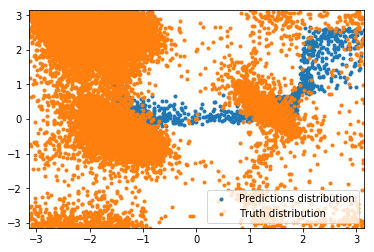

In [26]:
plt.scatter(refactor[:,0], refactor[:,1], marker=".")
plt.scatter(outputs[:n,0], outputs[:n,1], marker=".")
plt.legend(["Predictions distribution", "Truth distribution"], loc="lower right")
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.show()

In [41]:
# Correlattion coefficients are: - model.save("resnet_20_normalized012_5epochs.h5")
# Calculate Perason coefficient btwn cosines of both angles (true values and predicted ones)
cos_phi = np.corrcoef(preds[:, 1], out[:, 1])
cos_psi = np.corrcoef(preds[:, 3], out[:, 3])

print("Correlation coefficients - SOTA is Phi: 0.65 | Psi: 0.7")
print("Cos Phi: ", cos_phi[0,1])
print("Cos Psi: ", cos_psi[0,1])

Correlation coefficients - SOTA is Phi: 0.65 | Psi: 0.7
Cos Phi:  0.49297633001475943
Cos Psi:  0.5794534719985149


In [22]:
model.save("resnet_20_normalized012_5epochs.h5")

In [30]:
model = load_model("resnet_20_normalized012_5epochs.h5")